# NVCL_KIT 3D Plot Demonstration

*Acknowledgment: Borehole dataset courtesy of South Australia Department for Energy and Mining. (https://energymining.sa.gov.au/minerals)*

In [1]:
from nvcl_kit.reader import NVCLReader
from nvcl_kit.param_builder import param_builder

Define a narrow bounding box in South Australia ('sa') in which to search for boreholes

In [2]:
param = param_builder('wa', bbox = { "west": 121.51, "south": -33.26, "east": 121.56, "north": -33.18 }) 
# param = param_builder('sa', bbox = { "west": 134.761, "south": -31.228, "east": 134.767, "north": -31.224 })
if not param:
    print("Cannot build parameters for South Australia")

Initialise reader object and check for errors

In [3]:
reader = NVCLReader(param, log_lvl=10)
if not reader.wfs:
        print("ERROR!")

Get borehole information from WFS service

In [4]:
bh_list = reader.get_boreholes_list()

4


Create a dictionary of coordinates - key is NVCL id, value is (x,y) tuple

In [5]:
nvcl_id_list = [elem['nvcl_id'] for elem in bh_list]
xy_dict = {elem['nvcl_id']:(elem['x'],elem['y']) for elem in bh_list}

A function which fetches the first instance of borehole data

Assemble list of borehole data

In [6]:
print(nvcl_id_list)
bh_data_list = [reader.get_borehole_data_tmp(n_id, 50, 'Grp1 uTSAS') for n_id in nvcl_id_list]
# print(bh_data_list[0][:4])

['SGD001', 'SGD003', 'SGD004', 'SGD005']
nvcl_kit.svc_interface -- DEBUG - Sending: https://geossdi.dmp.wa.gov.au/NVCLDataServices//getDatasetCollection.html, b'holeidentifier=SGD001'
nvcl_kit.svc_interface -- DEBUG - Response[:100]: b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><DatasetCollection xmlns:ns2="http://www.open'
nvcl_kit.svc_interface -- DEBUG - Sending: https://geossdi.dmp.wa.gov.au/NVCLDataServices//getLogCollection.html, b'datasetid=5ee78faa-1bcf-4086-980e-dfebe08c8db&mosaicsvc=no'
nvcl_kit.svc_interface -- DEBUG - Response[:100]: b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><LogCollection xmlns:ns2="http://www.opengis.'
nvcl_kit.svc_interface -- DEBUG - Sending: https://geossdi.dmp.wa.gov.au/NVCLDataServices//getDownsampledData.html, b'logid=9e927cbe-0eb3-480b-a7eb-8515c6b9807&interval=50&outputformat=json&startdepth=0.0&enddepth=10000.0'
nvcl_kit.svc_interface -- DEBUG - Response[:100]: b'[{"roundedDepth":25.0,"classCount":351,"classText":"AMPHI

In [7]:
print(list((bh_data_list[0]).items())[:5])

[(25.0, namespace(className='Grp1 uTSAS', classCount=351, classText='AMPHIBOLE', colour=(1.0, 0.0, 1.0, 1.0))), (75.0, namespace(className='Grp1 uTSAS', classCount=2246, classText='AMPHIBOLE', colour=(1.0, 0.0, 1.0, 1.0))), (125.0, namespace(className='Grp1 uTSAS', classCount=3523, classText='AMPHIBOLE', colour=(1.0, 0.0, 1.0, 1.0))), (175.0, namespace(className='Grp1 uTSAS', classCount=1551, classText='WHITE-MICA', colour=(1.0, 1.0, 0.0, 1.0)))]


A routine to make data points for 3D plot, for one kind of mineral class

In [8]:
# A routine to make graded data points for 3D plot, for one kind of mineral class
#
# Parameters:
#  mineral_name (string): name of mineral class
#  bh_data_list (list): list of borehole data
#  offset (integer): small depth offset number used to ensure data points from each mineral class do not overwrite each other
#
# Returns a tuple (X,Y,Z,colours): 
#      X (dict): key = grade (float), value = plot's X value (float)
#      Y (dict): key = grade (float), value = plot's Y value (float)
#      Z (dict): key = grade (float), value = plot's Z (depth) value (float)
#      colours (dict): key = grade (float), value = plot's colour (float,float,float)
#
def make_splatter(mineral_name, bh_data_list, offset):
    X, Y, Z, colours = ({},{},{},{})
    
    # Mineral concentrations (counts) at each depth are sorted into 4 grades
    grades = [0.25, 0.5, 0.75, 1.00]
    for g in grades:
        X[g], Y[g], Z[g], colours[g] = ([], [], [], [])
        
    # Assemble X,Y,Z values and colours for plot
    
    # Loop over boreholes
    for n_idx, bh_data in enumerate(bh_data_list):
        if bh_data:
            
            # Loop over depths
            for depth in bh_data:
                
                # Loop over each mineral class at a given depth
                for elem in bh_data[depth]:
                    if elem.SCAL1 == mineral_name:
                        
                        # For each grade
                        for g in grades:
                            # Find appropriate grade for this mineral class
                            # Add to list of X,Y,Z & colours
                            X[g].append(xy_dict[nvcl_id_list[n_idx]][0])
                            Y[g].append(xy_dict[nvcl_id_list[n_idx]][1])
                            Z[g].append(depth+offset)
                            colours[g].append(elem.SCAL1)
                            break
    return X, Y, Z, colours

Create the 3D plot

TypeError: 'types.SimpleNamespace' object is not iterable

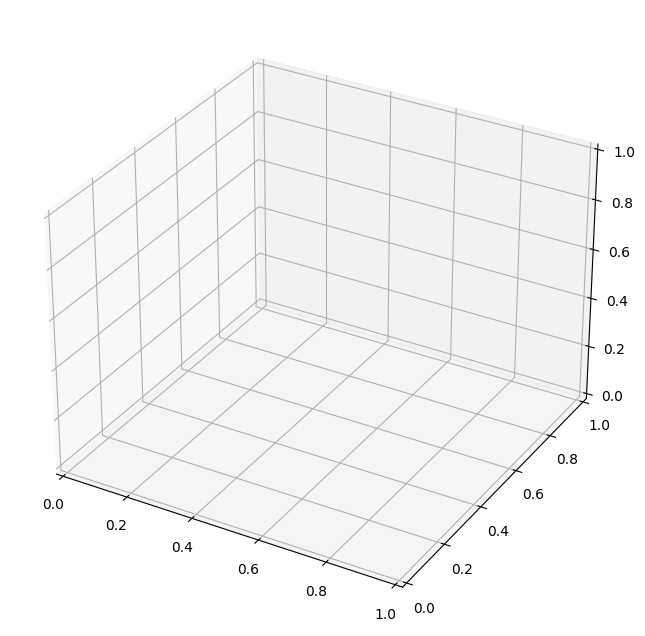

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Fetch X,Y,Z coords and colours for WHITE-MICA
X,Y,Z,colours = make_splatter('WHITE-MICA', bh_data_list, 0)

scatter_alpha = 0.02

s1 = 20
s2 = 40
s3 = 60
s4 = 80

# Draw the WHITE-MICA colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.0,0.9,0.0), s=s1, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.0,0.8,0.0), s=s2, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.0,0.7,0.0), s=s3, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.0,0.6,0.0), s=s4, edgecolors='none', alpha=scatter_alpha)

# Fetch X,Y,Z coords and colours for CARBONATE
X,Y,Z,colours = make_splatter('CARBONATE', bh_data_list, 15)

# Draw the CARBONATE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.0,0.9,0.9), s=s1, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.0,0.8,0.8), s=s2, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.0,0.7,0.7), s=s3, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.0,0.6,0.6), s=s4, edgecolors='none', alpha=scatter_alpha)

# Fetch X,Y,Z coords and colours for AMPHIBOLE
X,Y,Z,colours = make_splatter('AMPHIBOLE', bh_data_list, 30)

# Draw the AMPHIBOLE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.9,0.0,0.9), s=s1, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.8,0.0,0.8), s=s2, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.7,0.0,0.7), s=s3, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.6,0.0,0.6), s=s4, edgecolors='none', alpha=scatter_alpha)

# Fetch X,Y,Z coords and colours for CHLORITE
X,Y,Z,colours = make_splatter('CHLORITE', bh_data_list, 45)

# Draw the CHLORITE colours in different shades ("color") and point size ("s") for each grade
ax.scatter(X[0.25], Y[0.25], Z[0.25], color=(0.9,0.9,0.0), s=s1, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.5], Y[0.5], Z[0.5], color=(0.9,0.8,0.0), s=s2, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[0.75], Y[0.75], Z[0.75], color=(0.9,0.7,0.0), s=s3, edgecolors='none', alpha=scatter_alpha)
ax.scatter(X[1.0], Y[1.0], Z[1.0], color=(0.9,0.6,0.0), s=s4, edgecolors='none', alpha=scatter_alpha)

# Set axis labels
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_zlabel('depth')

# Invert the depth axis
ax.invert_zaxis()

# Set viewing angle and title
ax.view_init(45, 45)
plt.title('Mineral group concentrations west of Lake Everard (SA)')

# Assemble legend
legend_list = []
legend_list.append(mpatches.Patch(color=(0,1,0), label='WHITE-MICA'))
legend_list.append(mpatches.Patch(color=(0,1,1), label='CARBONATE'))
legend_list.append(mpatches.Patch(color=(1,0,1), label='AMPHIBOLE'))
legend_list.append(mpatches.Patch(color=(1,1,0), label='CHLORITE'))

# Show graph
plt.legend(handles=legend_list)
plt.show()